# The Kennedy-O’Hagan Predictive Model

Created by Jiale Shi (jshi1@nd.edu)
These examples and codes were adapted from:
* McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers*, *Chapter 11 : Predictive Models Informed by Simulation, Measurement, and Surrogates*, Springer, https://link.springer.com/chapter/10.1007/978-3-319-99525-0_11
 and its supplementary material **Calibration Simple with Discrep.ipynb**
 

In [1]:
## import all needed Python libraries here
from pyDOE import *
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import math
from scipy.stats import multivariate_normal
from scipy.stats import  norm
import numpy as np
np.random.seed(1000)

In [2]:
#covariance function
def cov(x,y,beta,l,alpha):
    exponent = np.sum(beta*np.abs(x-y)**alpha)
    return 1/l * math.exp(-exponent)

In [3]:
#likelihood function
def likelihood(z,x,beta,lam,alpha, beta_t, lam_t, alpha_t, meas_cov, N,M):
    Sig_z = np.zeros((N+M,N+M))
    #fill in matrix with sim covariance
    for i in range(N+M):
        for j in range(i+1):
            tmp = cov(x[i,:],x[j,:],beta,lam,alpha)
            if (i < N):
                tmp += cov(x[i,0], x[j,0], beta_t, lam_t, alpha_t)
            Sig_z[i,j] = tmp
            Sig_z[j,i] = tmp
    #add in measurement error cov
    Sig_z[0:N,0:N] += meas_cov
    #print(Sig_z)
    likelihood = multivariate_normal.logpdf(z,mean=0*z, cov=Sig_z,allow_singular=True)
    return likelihood

## Toy example of KOH model
To demonstrate the behavior of the predictive model, we consider a simple simulation code

$$\eta (x,t) = \sin xt$$

We also consider measurement generated from the function

$$y(x) = \sin 1.2 x + 0.1 x + \epsilon =\eta(x,1.2)+0.1 x + \epsilon$$

where $\epsilon$ is a measurement error that is normally distributed with mean 0 and standard deviation 0.005.
We will use the Kennedy-O'Hagan model to estimate the calibration parameter, which in this case has a true value of $t=1.2$, and fit **a discrepancy function**. We know that the true discrepancy function is linear, and we can compare our estimate to the true function.



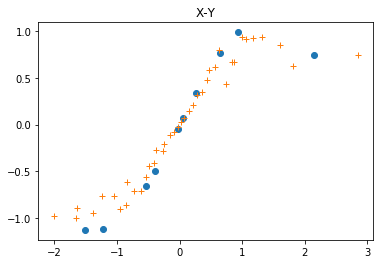

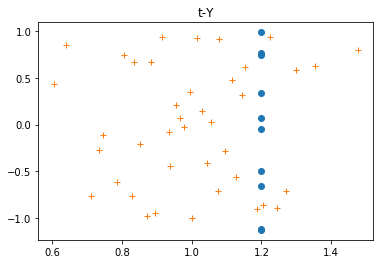

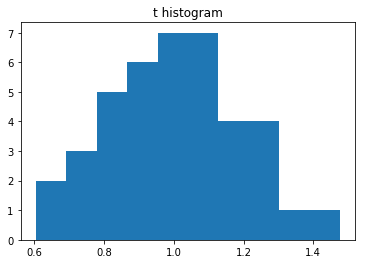

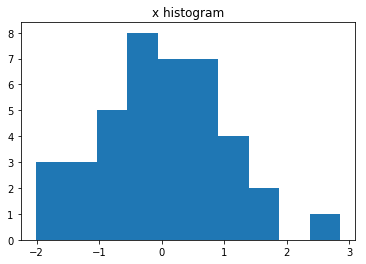

In [4]:
#pick x points
N = 10
M = 40
x = np.zeros((N+M,2))

#10 measurement by sampling x from a standard normal distribution
x[0:N,0] = np.reshape(norm.ppf(lhs(1, N)),N)

#sample the simulation with 40 points usng 2D  lhs of 
#standard normal for x and a normal variable with mean 1 
#and standard deviation 0.2 for the t variable
x[N:(N+M),:] = lhs(2, M)
x[N:(N+M),0] = norm.ppf(x[N:(N+M),0] ) # for x 
x[N:(N+M),1] = norm.ppf(x[N:(N+M),1], loc=1,scale=0.2 )  # for t variable

z = np.zeros(N+M)
sd_meas = 0.005
simfunc_n = lambda x,t: np.sin(t*x)
simfunc = lambda x: simfunc_n(x,1.2)
truefunc = lambda x: simfunc(x) + 0.1*x
z[0:N] = truefunc(x[0:N,0]) + np.random.normal(size=N,loc=0,scale=sd_meas)
z[N:(M+N)] = simfunc_n(x[N:(N+M),0], x[N:(M+N),1])


plt.title("X-Y")
plt.plot(x[0:N,0], z[0:N],'o')
plt.plot(x[N:(N+M),0], z[N:(M+N)],'+')
plt.show()

plt.title("t-Y")
plt.plot(1.2*np.ones(N), z[0:N],'o')
plt.plot(x[N:(N+M),1], z[N:(M+N)],'+')
plt.show()

plt.title("t histogram")
plt.hist(x[N:(N+M),1])
plt.show()

plt.title("x histogram")
plt.hist(x[N:(N+M),0])
plt.show()

## Prior for hyperparameters

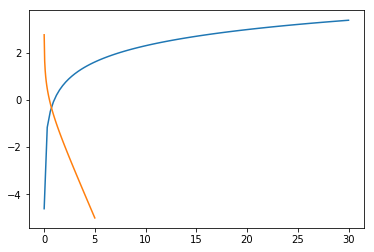

In [5]:
beta_prior = lambda beta: np.sum(-0.5*np.log(1-np.exp(-beta))-beta)
lambda_prior = lambda lam: (5-1)*np.log(lam) - 5*lam


beta_t_prior = lambda beta: (-0.6*np.log(1-np.exp(-beta))-beta)
lambda_t_prior = lambda lam: np.log(lam) - 0.001*lam

plt.plot(np.linspace(0.01,30-1e-3,100),lambda_t_prior(np.linspace(0.01,30-1e-3,100)))
plt.plot(np.linspace(0.01,5-1e-3,100),beta_t_prior(np.linspace(0.01,5-1e-3,100)))
plt.show()

t_0 = np.array([1.2])
t_curr = t_0.copy()
t_sd = np.array([0.05])
beta_curr = np.array([.95,.95])
beta_t_curr = np.array([.95])
lam_curr = [0.5,1]
lam_sd = 0.1
beta_sd = 0.05
meas_cov = sd_meas**2*np.identity(N)
x[0:N,1] = t_curr.copy()
old_like = (likelihood(z,x,beta_curr,lam_curr[0],2,
                       beta_t_curr,lam_curr[1],2,meas_cov, N,M) + beta_prior(beta_curr) + lambda_prior(lam_curr[0]) +
           beta_t_prior(beta_t_curr) + lambda_t_prior(lam_curr[1]))
beta_hist = np.resize(beta_curr.copy(),(1,2))
beta_t_hist = np.resize(beta_t_curr.copy(),(1,1))
lam_hist = np.resize(lam_curr.copy(),(1,2))
t_hist = np.resize(t_curr.copy(),(1,1))



## Generate $10^4$ MCMC chain
We generate $10^4$ MCMC samples after a burn-in period of $10^4$ samples to fit the prediction model for this data.
In this problem the chain centers on the correct value of $t$ in a small number of samples.

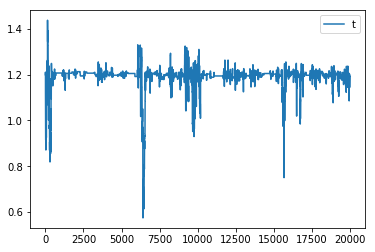

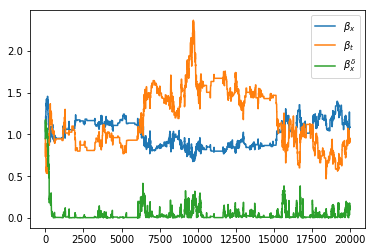

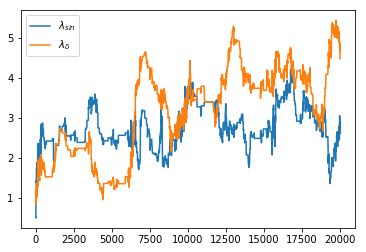

In [6]:
for times in range(1):
    Steps = 20000
    for i in range(Steps):

        #propose new thetas
        good = 0
        while not(good):
            t_new = np.random.normal(size=1,loc=t_curr,scale=t_sd)
            good = np.max(np.abs(t_new)) <= 5
        #propose new hyperparams
        good = 0
        while not(good):
            beta = np.abs(np.random.normal(size=2,loc=beta_curr,scale=beta_sd))
            good = (np.max(np.abs(beta)) <= 100) and (np.min(np.abs(beta)) > 0) 
        good = 0
        while not(good):
            beta_t = np.abs(np.random.normal(size=1,loc=beta_t_curr,scale=beta_sd))
            good = (np.max(np.abs(beta_t)) <= 100) and (np.min(np.abs(beta_t)) > 0) 
        lam = np.abs(np.random.normal(size=2,loc=lam_curr,scale=lam_sd))
        x[0:N,1] = t_new.copy()
        #print(beta,lam,t_new)
        new_like = (likelihood(z,x,beta,lam[0],2,
                               beta_t,lam[1],2,meas_cov, N,M) + beta_prior(beta) + lambda_prior(lam[0]) +
                   beta_t_prior(beta_t) + lambda_t_prior(lam_curr[1]))
        #print(new_like,old_like)

        accept_prob = new_like - old_like
        alpha = np.random.rand()
        #print(accept_prob)
        if (new_like > old_like) or (math.log(alpha) < accept_prob):
            #accept
            beta_hist = np.append(beta_hist,np.resize(beta,(1,2)),axis=0)
            beta_t_hist = np.append(beta_t_hist,np.resize(beta_t,(1,1)),axis=0)
            lam_hist = np.append(lam_hist,np.resize(lam,(1,2)),axis=0)
            t_hist = np.append(t_hist,np.resize(t_new,(1,1)),axis=0)
            t_curr = t_new.copy()
            beta_curr = beta.copy()
            beta_t_curr = beta_t.copy()
            lam_curr = lam.copy()
            old_like = new_like
        else:
            #reject
            beta_hist = np.append(beta_hist,np.resize(beta_curr,(1,2)),axis=0)
            beta_t_hist = np.append(beta_t_hist,np.resize(beta_t_curr,(1,1)),axis=0)
            lam_hist = np.append(lam_hist,np.resize(lam_curr,(1,2)),axis=0)
            t_hist = np.append(t_hist,np.resize(t_curr,(1,1)),axis=0)
    #np.savetxt(fname="d_beta_1_s.csv",delimiter=",",X=beta_hist)
    #np.savetxt(fname="d_lam_1_s.csv",delimiter=",",X=lam_hist)
    #np.savetxt(fname="d_theta_1_s.csv",delimiter=",",X=t_hist)
    plt.plot(t_hist[0:-1:(times+1),0],label="t")
    plt.legend(loc="best")
    plt.show()
    plt.plot(beta_hist[0:-1:(times+1),0],label=r'$\beta_{x}$')
    plt.plot(beta_hist[0:-1:(times+1),1],label=r'$\beta_{t}$')
    #plt.legend(loc="best")
    #plt.show()
    plt.plot(beta_t_hist[0:-1:(times+1),0],label=r'$\beta_{x}^{\delta}$')
    plt.legend(loc="best")
    plt.show()
    plt.plot(lam_hist[0:-1:(times+1),0],label=r'$\lambda_{sin}$')
    plt.plot(lam_hist[0:-1:(times+1),1],label=r'$\lambda_{\delta}$')
    plt.legend(loc="best")
    plt.show()

## Draw a sample from the Markov chain and use those values of hyperparamters to construct a GP model using the data  and make prediction

In [7]:
#GPR with uncalibrated
#construct a GP Model
def GPR(X,y,Xstar,k,sigma_n,M,cov_mat,cov_t,disc=1):
    N = y.size
    #build covariance matrix
    K = np.zeros((N,N))
    kstar = np.zeros(N)
    for i in range(N):
        for j in range(0,i+1):
            K[i,j] = k(X[i,:],X[j,:])
            if (i < M):
                K[i,j] += cov_t(X[i,0], X[j,0])
            if not(i==j):
                K[j,i] = K[i,j]
            else:
                K[i,j] += sigma_n**2
    
    #add in measurement error cov
    K[0:M,0:M] += meas_cov
    #compute Cholesky factorization
    L = np.linalg.cholesky(K)
    u = np.linalg.solve(L,y)
    u = np.linalg.solve(np.transpose(L),u)
    #now loop over prediction points
    Nstar = Xstar.shape[0]
    ystar = np.zeros(Nstar)
    varstar = np.zeros(Nstar)
    kstar = np.zeros(N)
    for i in range(Nstar):
        #fill in kstar
        for j in range(N):
            kstar[j] = k(Xstar[i,:],X[j,:]) 
            if (j < M):
                kstar[j] += disc*cov_t(Xstar[i,0], X[j,0]) #+ cov_mat[0,0]
        ystar[i] = np.dot(u,kstar)
        tmp_var = np.linalg.solve(L,kstar)
        varstar[i] = k(Xstar[i,:],Xstar[i,:]) - np.dot(tmp_var,tmp_var)
    return ystar, varstar
def cov(x,y,beta,l,alpha):
    exponent = np.sum(beta*np.abs(x-y)**alpha)
    return 1/l * math.exp(-exponent)

## Test the predictive model

In [36]:
Ns = 100
Np = 20
samps = np.random.randint(high=t_hist.size,low=10**4, size= Ns) # The burn- in period used was 10**4
Xstar = np.zeros((Np,2))
ystar = np.zeros(Ns)
varstar = ystar*0

deltastar = np.zeros(Ns)
delta_pred = np.zeros((Np,3))
Xstar[:,0] = np.random.uniform(size=Np,low=-3,high=3)
ytrue = truefunc(Xstar[:,0]) + np.random.normal(size=Np,loc=0,scale=sd_meas) 
print(Xstar,ytrue)
ypred = np.zeros((Np,Ns))
for i in range(Ns):
    Xstar[:,1] = t_hist[samps[i],:]
    x[0:N,1] = t_hist[samps[i]]
    cov_f = lambda x,y: cov(x,y,beta=beta_hist[samps[i],:],l=lam_hist[samps[i],0],alpha=2)
    cov_t = lambda x,y: cov(x,y,beta=beta_t_hist[samps[i],:],l=lam_hist[samps[i],1],alpha=2)
    ypred[:,i],varstar = GPR(x,
                              z,Xstar,cov_f,0.00000,M=N,
                              cov_mat=sd_meas**2*np.identity(N),cov_t=cov_t)

[[-0.44828415  0.        ]
 [-0.25972319  0.        ]
 [-1.09080598  0.        ]
 [-0.30851928  0.        ]
 [-0.82030768  0.        ]
 [-2.92667314  0.        ]
 [-2.53935381  0.        ]
 [-1.000954    0.        ]
 [ 0.81905071  0.        ]
 [ 1.66067398  0.        ]
 [ 0.35580845  0.        ]
 [-2.84537719  0.        ]
 [ 1.70915215  0.        ]
 [ 1.38722257  0.        ]
 [-0.73765065  0.        ]
 [-0.88984099  0.        ]
 [-0.63780511  0.        ]
 [ 0.4194276   0.        ]
 [-0.77184334  0.        ]
 [ 1.77860956  0.        ]] [-0.55366149 -0.32313923 -1.07398604 -0.39618083 -0.91812534  0.06620126
 -0.34965838 -1.02915995  0.91213627  1.08553533  0.44592352 -0.0132474
  1.05906346  1.13743606 -0.84737392 -0.96015562 -0.75281753  0.52270703
 -0.882381    1.00945828]


[-0.5609482822938067, -0.3357547772462933, -1.0797545050632353, -0.3959789521270604, -0.9196574338404274, -0.5716647059317715, -0.71369406311223, -1.0374871999403108, 0.9150860895397054, 1.0394390102233073, 0.44881582564212963, -0.6001237922873386, 1.0139834680817028, 1.1229210163139853, -0.8522986026516024, -0.9699789345189853, -0.7608390983380835, 0.5236563500649779, -0.8811219023426815, 0.9736509268671515]


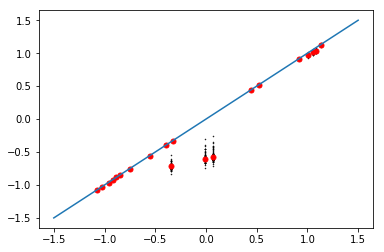

In [37]:
ypred_mean=[]
for i in range(Np):
    ypred_mean.append(np.mean(ypred[i,:]))
print (ypred_mean)
for i in range(Ns):
    plt.plot(ytrue[0:Np],ypred[:,i],'.',c='black', ms = '1')
plt.plot(ytrue[0:Np], ypred_mean,'.',c='red',ms=10)
plt.plot([-1.5,1.5],[-1.5,1.5])
#plt.ylim([0,1.2])
#plt.xlim([0,1.2])
plt.show()
#compare with Fig. 11.8
#Prediction from the predictive model versus actual at 20 new measurements generated. 
#Each point represents the mean of the estimate generated using 100 different samples from the MCMC chain
# and the error bars give the range of those estimates.

To make a prediction using the KOH model, we have to modify the difinition of $\bf{k}^*$ to include the kernel function for the discrepancy function. Each element of the vector is
$$(\bf{k})^{*} = k({\bf{x_{i}, t, x^*, t^*}}) + k_{\delta}(\bf{x_{i}, x^*}), \  \   \  i = 1, ..., N$$
$$(\bf{k})^{*} = k({\bf{x_{i}, t, x^*, t^*}}) , \  \   \    i = N+1, ..., N+M$$

where $k({\bf{x_{i}, t, x^*, t^*}})$ is the covariance kernel function for simulations. The prediction requires this definition of $\bf{k}^{*}$ to inform the prediction vector that the covariance between the predicition should have a different form when compared with the simuation training points versus the measurement point. 

## Plot surface

### Full prediction

In [47]:

Ns = 100
Np = 100
samps = np.random.randint(high=t_hist.size,low=10**4, size= Ns)
Xstar = np.zeros((Np,2))
Xstar[:,0] = np.linspace(-3,3,Np)
ystar = np.zeros(Ns)
varstar = ystar*0

deltastar = np.zeros(Ns)
delta_pred = np.zeros((Np,3))
ytrue = truefunc(Xstar[:,0]) + np.random.normal(size=Np,loc=0,scale=sd_meas) 
ypred = np.zeros((Np,Ns))

for i in range(Ns):
        Xstar[:,1] = t_hist[samps[i],:]
        x[0:N,1] = t_hist[samps[i]]
        cov_f = lambda x,y: cov(x,y,beta=beta_hist[samps[i],:],l=lam_hist[samps[i],0],alpha=2)
        cov_t = lambda x,y: cov(x,y,beta=beta_t_hist[samps[i],:],l=lam_hist[samps[i],1],alpha=2)
        ypred[:,i],varstar = GPR(x,
                                  z,Xstar,cov_f,0,M=N,
                                  cov_mat=sd_meas**2*np.identity(N),cov_t=cov_t)

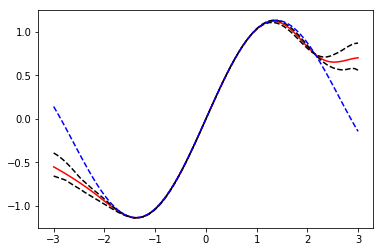

In [48]:
#plt.plot(Xstar[:,0], ypred[:,0],'o')
plt.plot(Xstar[:,0], np.mean(ypred,axis=1),'-',c='red')
plt.plot(Xstar[:,0], np.percentile(ypred,q=95,axis=1),'--',c='black')
plt.plot(Xstar[:,0], np.percentile(ypred,q=5,axis=1),'--',c='black')
plt.plot(Xstar[:,0], truefunc(Xstar[:,0]),'k--' ,c='blue')

### Prediction without a discrepancy
The evaluation of the expected simulation result from the predictive model can be accomplished by removing the $k_{\delta}(\bf{x}_{i}-\bf{x}^*)$ term from Eq.(11.23) to get a prediction without a discrepancy. This simulation prediction can then be used to evaluate the discrepancy function via substraction from the full prediction.

In [49]:

ystar = np.zeros(Ns)
varstar = ystar*0

deltastar = np.zeros(Ns)
delta_pred = np.zeros((Np,3))
ytrue = truefunc(Xstar[:,0]) + np.random.normal(size=Np,loc=0,scale=sd_meas) 
ypred_sim = np.zeros((Np,Ns))

# prediction without discrepancy by setting disc=0
for i in range(Ns):
        Xstar[:,1] = t_hist[samps[i],:]
        x[0:N,1] = t_hist[samps[i]]
        cov_f = lambda x,y: cov(x,y,beta=beta_hist[samps[i],:],l=lam_hist[samps[i],0],alpha=2)
        cov_t = lambda x,y: cov(x,y,beta=beta_t_hist[samps[i],:],l=lam_hist[samps[i],1],alpha=2)
        ypred_sim[:,i],varstar = GPR(x,
                                  z,Xstar,cov_f,0,M=N,
                                  cov_mat=sd_meas**2*np.identity(N),cov_t=cov_t,disc=0)
    

## Simulation $\eta(x,t)$

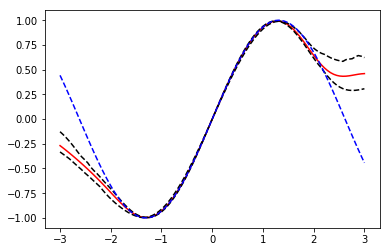

In [50]:
plt.plot(Xstar[:,0], np.mean(ypred_sim,axis=1),'-',c='red')
plt.plot(Xstar[:,0], np.percentile(ypred_sim,q=95,axis=1),'--',c='black')
plt.plot(Xstar[:,0], np.percentile(ypred_sim,q=5,axis=1),'--',c='black')
plt.plot(Xstar[:,0], simfunc(Xstar[:,0]),'k--',c='blue')

## Discrepancy $\delta(x)$

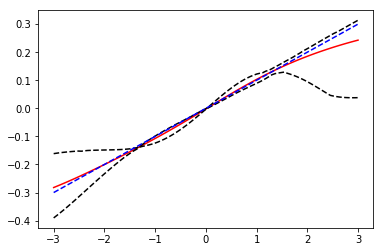

In [51]:
plt.plot(Xstar[:,0], np.mean(ypred-ypred_sim,axis=1),'-',c='red')
plt.plot(Xstar[:,0], np.percentile(ypred-ypred_sim,q=95,axis=1),'--', c='black')
plt.plot(Xstar[:,0], np.percentile(ypred-ypred_sim,q=5,axis=1),'--',c='black')
plt.plot(Xstar[:,0], truefunc(Xstar[:,0])-simfunc(Xstar[:,0]),'k--',c='blue')